# Predicting Appointment No Shows  with Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background


This notebook uses XGBoost to predict whether a patient will be a no-show for a medical appointment.The dataset was downloaded from Kaggle https://www.kaggle.com/joniarroba/noshowappointments. The appointment data of 110,527 records was collected from medical clinics in the city of Vitoria, Brazil, over a three month period in 2016.

The following steps were undertaken:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).


## Notes
Tried turning age and waiting time into categorical columns to see if that improved the model. Made no real difference.

In [ ]:
bucket = 'sagemaker-sf-strategenics'
prefix = 'sagemaker/DEMO-xgboost-noShow'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Bring in the Python libraries that we'll use throughout the analysis

In [ ]:
from datetime import date
from datetime import time
from datetime import datetime
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference
import seaborn as sns

---

## Data
The csv file containing the data is stored in an S3 bucket. First let's read the data file into a Pandas data frame.

In [8]:
data_key = 'appointmentData.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

noShow= pd.read_csv(data_location)

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
noShow
noShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Let's start by renaming some of the columns

In [9]:
noShow.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Disabilities'}, inplace = True)

print(noShow.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Disabilities', 'SMS_received', 'No-show'],
      dtype='object')


As we have the date that the appointment was scheduled and the date of the appointment, we can calculate the number of days that the patient waited for the appointment.

First we have to convert the two date columns to a date format.

In [11]:
#convert date columns to a date format
noShow['tempSchedDate'] = pd.to_datetime(noShow['ScheduledDay'])
noShow['tempAppDate'] = pd.to_datetime(noShow['AppointmentDay'])
#get the date part of the date columns, as the Scheduled date has a time component but the appointment day does not
noShow['AppointmentDate']= noShow['tempAppDate'].dt.date
noShow['AppointmentBooked']= noShow['tempSchedDate'].dt.date
#calculate the waiting time
noShow['WaitingTime'] = (noShow.AppointmentDate - noShow.AppointmentBooked).dt.days

print(noShow.AppointmentBooked.head())
print(noShow.AppointmentDate.head())
print(noShow.WaitingTime.head())
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page


0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentBooked, dtype: object
0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentDate, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: WaitingTime, dtype: int64


Calculate the day of the week for the appointment day and drop the original scheduled and appointment columns.

In [12]:
#Find the day of the week of the appointment
noShow['DayOfWeek'] = noShow['tempAppDate'].dt.day_name()

#drop the columns no longer needed
noShow = noShow.drop(['ScheduledDay','AppointmentDay','tempSchedDate','tempAppDate'], axis=1)

print(noShow.AppointmentDate.head())
print(noShow.DayOfWeek.head())
print('Day of week:', sorted(noShow.DayOfWeek.unique()))

0    2016-04-29
1    2016-04-29
2    2016-04-29
3    2016-04-29
4    2016-04-29
Name: AppointmentDate, dtype: object
0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
Name: DayOfWeek, dtype: object
Day of week: ['Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday']


Check that we don't have any duplicate data by looking at the appointmentID which should be unique.

In [13]:
print('Total appointments: ' + format(noShow.shape[0], ",d"))
print('Unique appointments: ' + format(noShow['AppointmentID'].unique().shape[0], ",d"))

Total appointments: 110,527
Unique appointments: 110,527


    There are no duplicate Appointment IDs so we will index the data by AppointmentID. We also need to convert PatientId to an integer.

In [14]:
noShow.PatientId = noShow.PatientId.astype('int64')
print(noShow.PatientId.head())
noShow.set_index('AppointmentID', inplace = True)

0     29872499824296
1    558997776694438
2      4262962299951
3       867951213174
4      8841186448183
Name: PatientId, dtype: int64


In [ ]:
noShow
noShow.info()

### Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

col_0,% observations
Gender,
F,0.649977
M,0.350023


col_0,% observations
Neighbourhood,
AEROPORTO,0.000072
ANDORINHAS,0.020466
ANTÔNIO HONÓRIO,0.002452
ARIOVALDO FAVALESSA,0.002551
BARRO VERMELHO,0.003827
BELA VISTA,0.017254
BENTO FERREIRA,0.007763
BOA VISTA,0.002823
BONFIM,0.025089


col_0,% observations
No-show,
No,0.798067
Yes,0.201933


col_0,% observations
AppointmentDate,
2016-04-29,0.029269
2016-05-02,0.039592
2016-05-03,0.038506
2016-05-04,0.037710
2016-05-05,0.038660
2016-05-06,0.035095
2016-05-09,0.040895
2016-05-10,0.038977
2016-05-11,0.040479


col_0,% observations
AppointmentBooked,
2015-11-10,0.000009
2015-12-03,0.000009
2015-12-07,0.000090
2015-12-08,0.000335
2015-12-14,0.000054
2015-12-15,0.000063
2016-01-04,0.000009
2016-01-05,0.000036
2016-01-07,0.000118


col_0,% observations
DayOfWeek,
Friday,0.172076
Monday,0.205515
Saturday,0.000353
Thursday,0.156043
Tuesday,0.231980
Wednesday,0.234033


,PatientId,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Disabilities,SMS_received,WaitingTime
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,10.183702
std,2.560949e+14,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921700e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000


Age: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Waiting time: [-6, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 115, 117, 119, 122, 123, 125, 126, 127, 132, 133, 139, 142, 146, 151, 155, 162, 169, 176, 179]


col_0,DayOfWeek
DayOfWeek,
Friday,19019
Monday,22715
Saturday,39
Thursday,17247
Tuesday,25640
Wednesday,25867


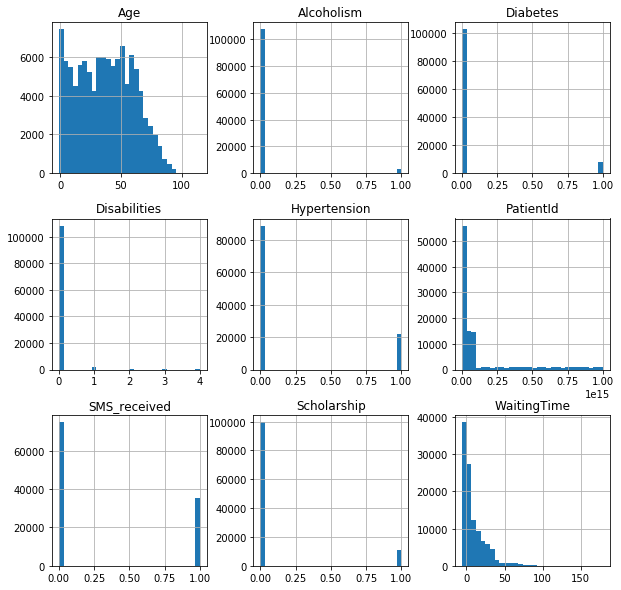

In [15]:
# Frequency tables for each categorical feature
for column in noShow.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=noShow[column], columns='% observations', normalize='columns'))
    

# Histograms for each numeric features
display(noShow.describe())
%matplotlib inline
hist = noShow.hist(bins=30, figsize=(10, 10))

print('Age:', sorted(noShow.Age.unique()))
print('Waiting time:', sorted(noShow.WaitingTime.unique()))
display(pd.crosstab(index=noShow['DayOfWeek'],columns='DayOfWeek'))


# Data Summary

* There are 110,527 patient records, and 13 features for each patient
* The features are mixed; some numeric, some categorical


*Features:*
* `Age`: Patient's age. Integer -1 to 115
* `Gender`: Patient's gender, string M,F
* `Alcoholism`: Binary, 1=yes
* `Diabetes`:Binary, 1= yes
* `Hypertension`:Binary, 1= yes
* `Disabilities`: The number of disabilities for a patient. Integer, 1-4
* `Scholarship`: This indicates whether the patient receives financial support from the government. Binary, 1=yes
* `Neighbourhood`: This is the location of the medical clinic. String, 80 values
* `SMS_receceived`:Whether they received a SMS reminder before the appointment. Binary, 1= yes
* `AppointmentBooked`: Date that the appointment was booked
* `AppointmentDate`: Date of the appointment
* `DayOfWeek`: The weekday of the appointment. Integer, 0-5
* `WaitingTime`: The number of days between booking the appointment and the appointment date. Integer, -6 to 179


*Target variable:*
* `No-show`: Was the patient a no-show? Binary: 1=yes,0=no
Overall, 20% of the patients were no-shows.

In [16]:
noShow['Age'] = np.where(noShow['Age']<0, np.nan, noShow['Age'])
noShow['Age'].describe()
noShow['WaitingTime'] = np.where(noShow['WaitingTime']<0, np.nan, noShow['WaitingTime'])
noShow['WaitingTime'].describe()

count    110522.000000
mean         10.184253
std          15.255115
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: WaitingTime, dtype: float64

Disability has values from 0-5, indicating the number of disabilities a patient has. We will turn this into a binary column to indicate whether the patient has a disablity or not.

In [17]:
noShow['Disability'] = np.where(noShow['Disabilities']>1, 1, noShow['Disabilities'])
print('Disability:', sorted(noShow.Disability.unique()))
count = noShow.groupby(['Disability', 'Disabilities']).size() 
print(count)  


Disability: [0, 1]
Disability  Disabilities
0           0               108286
1           1                 2042
            2                  183
            3                   13
            4                    3
dtype: int64


In [ ]:
Now we will look at patient history as it is possible that people who have a previous no-show are more likely to no-show again.

In [18]:
#determine if a patient has had a previous appointment
noShow.sort_values(by=['PatientId','AppointmentDate'], inplace=True)
pd.options.display.max_rows=100
noShow['PreviousAppointment'] = noShow.sort_values(by = ['PatientId','AppointmentDate']).groupby(['PatientId']).cumcount()
#print(noShow[['PatientId','AppointmentDate', 'PreviousAppointment']].head(100)) 


a = noShow.groupby(pd.cut(noShow.PreviousAppointment, bins = [-1, 0,1,2,3,4,5, 85], include_lowest = True))[['PreviousAppointment']].count()
b = pd.DataFrame(a)
b.set_index(pd.Series(['0', '1', '2', '3', '4', '5', '> 5']))

,PreviousAppointment
0,62299
1,24379
2,10484
3,4984
4,2617
5,1498
> 5,4264


In [ ]:
Calculate whether the patient has a previous no-show

In [20]:
noShow['NoShow']=np.where(noShow['No-show'] == "Yes", 1,0)
count = noShow.groupby(['No-show', 'NoShow']).size() 
print(count)

#noShow['PreviousNoShow'] = (noShow[noShow['PreviousAppointment'] > 0].sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['NumberOfPreviousNoShow'] = (noShow.sort_values(['PatientId', 'AppointmentDate']).groupby(['PatientId'])['NoShow'].cumsum())
noShow['PreviousNoShows']=noShow['NumberOfPreviousNoShow']-noShow['NoShow']
noShow['PreviousNoShowProp'] = noShow['PreviousNoShows']/ noShow[noShow['PreviousAppointment'] > 0]['PreviousAppointment']

pd.options.display.max_rows=100
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
print(noShow[['PatientId','AppointmentDate', 'No-show', 'PreviousAppointment','PreviousNoShows','PreviousNoShowProp']].head(100)) 

noShow['PreviousNoShowProp'].describe()

No-show  NoShow
No       0         88208
Yes      1         22319
dtype: int64
               PatientId AppointmentDate No-show  PreviousAppointment  PreviousNoShows  PreviousNoShowProp
AppointmentID                                                                                             
5751990            39217      2016-06-03      No                    0                0                 NaN
5760144            43741      2016-06-01      No                    0                0                 NaN
5712759            93779      2016-05-18      No                    0                0                 NaN
5637648           141724      2016-05-02      No                    0                0                 NaN
5637728           537615      2016-05-06      No                    0                0                 NaN
5680449          5628261      2016-05-13     Yes                    0                0                 NaN
5718578         11831856      2016-05-19      No                 

count    48228.000000
mean         0.198413
std          0.343029
min          0.000000
25%          0.000000
50%          0.000000
75%          0.333333
max          1.000000
Name: PreviousNoShowProp, dtype: float64


Now let's look at how our features relate to the probability of not turning up to the appointment.

In [21]:
#drop columns that we no longer need
noShow = noShow.drop(['NoShow','AppointmentBooked','PreviousNoShows'], axis=1)
noShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 18 columns):
PatientId                 110527 non-null int64
Gender                    110527 non-null object
Age                       110526 non-null float64
Neighbourhood             110527 non-null object
Scholarship               110527 non-null int64
Hypertension              110527 non-null int64
Diabetes                  110527 non-null int64
Alcoholism                110527 non-null int64
Disabilities              110527 non-null int64
SMS_received              110527 non-null int64
No-show                   110527 non-null object
AppointmentDate           110527 non-null object
WaitingTime               110522 non-null float64
DayOfWeek                 110527 non-null object
Disability                110527 non-null int64
PreviousAppointment       110527 non-null int64
NumberOfPreviousNoShow    110527 non-null int64
PreviousNoShowProp        48228 non-null float64
dtypes: 

In [ ]:
noShow.info()

Change age and waiting time to categorical columns


In [23]:
def WaitingTimeCat(days):
    if days == 0:
        return '0 days'
    elif  days in range(1,8):
        return '1-7 days'
    elif  days in range(8,15):
        return '8-14 days'
    elif days in range(15, 29):
        return '15-28 days'
    else:
        return '> 28 days'
    
def AgeCat(years):
    if years in range(0,5):
        return '0-4 years'
    elif  years in range(5,15):
        return '05-14 years'
    elif  years in range(15,25):
        return '15-24 years'
    elif years in range(25, 35):
        return '25-34 years'
    elif years in range(35, 45):
        return '35-44 years'
    elif years in range(45, 55):
        return '45-54 years'
    elif years in range(55, 65):
        return '55-64 years'
    else:
        return '> 64 years'   
noShow['WaitingTimeCat'] = noShow.WaitingTime.apply(WaitingTimeCat)
noShow['AgeCat'] = noShow.Age.apply(AgeCat)



In [24]:
display(pd.crosstab(noShow.Age,noShow.AgeCat))

AgeCat,0-4 years,05-14 years,15-24 years,25-34 years,35-44 years,45-54 years,55-64 years,> 64 years
Age,,,,,,,,
0.0,3539,0,0,0,0,0,0,0
1.0,2273,0,0,0,0,0,0,0
2.0,1618,0,0,0,0,0,0,0
3.0,1513,0,0,0,0,0,0,0
4.0,1299,0,0,0,0,0,0,0
5.0,0,1489,0,0,0,0,0,0
6.0,0,1521,0,0,0,0,0,0
7.0,0,1427,0,0,0,0,0,0
8.0,0,1424,0,0,0,0,0,0


In [ ]:
#display(pd.crosstab(index=noShow['PreviousAppointment'],columns='PreviousAppointment'))

filterDf = noShow[(noShow['PatientId'] == 822145925426128)]
filterDf2 = filterDf[['PatientId','AppointmentDate','No-show','PreviousAppointment','Age','Diabetes']].copy()
filterDf2.info()
#filterDf.set_index('AppointmentID', inplace = True)
print(filterDf2.head(100)) 

In [25]:
#create dummy variables for no-show so that we can calculate the probability of being a no-show


noShow['No-show'] = noShow['No-show'].astype('category')
noShow2 = noShow.join(pd.get_dummies(noShow['No-show']))


noShow2.rename(columns = {'No': 'Attended',
                         'Yes': 'NoShow'}, inplace = True)
noShow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 22 columns):
PatientId                 110527 non-null int64
Gender                    110527 non-null object
Age                       110526 non-null float64
Neighbourhood             110527 non-null object
Scholarship               110527 non-null int64
Hypertension              110527 non-null int64
Diabetes                  110527 non-null int64
Alcoholism                110527 non-null int64
Disabilities              110527 non-null int64
SMS_received              110527 non-null int64
No-show                   110527 non-null category
AppointmentDate           110527 non-null object
WaitingTime               110522 non-null float64
DayOfWeek                 110527 non-null object
Disability                110527 non-null int64
PreviousAppointment       110527 non-null int64
NumberOfPreviousNoShow    110527 non-null int64
PreviousNoShowProp        48228 non-null float64
Waitin

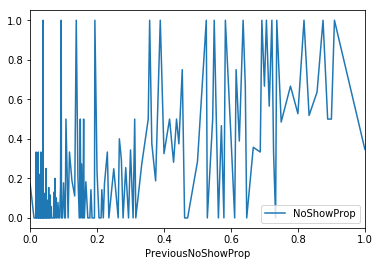

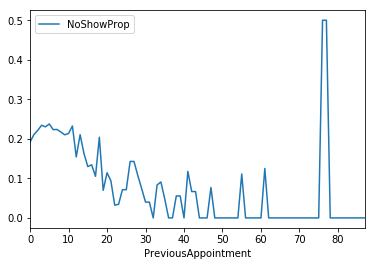

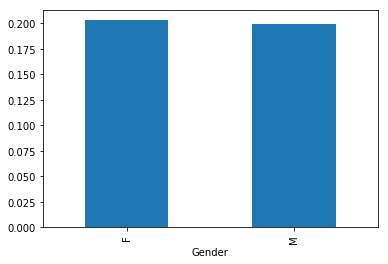

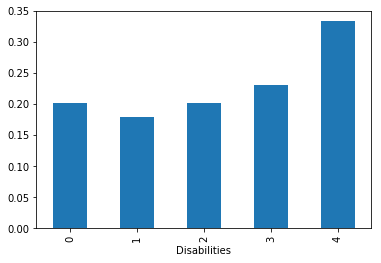

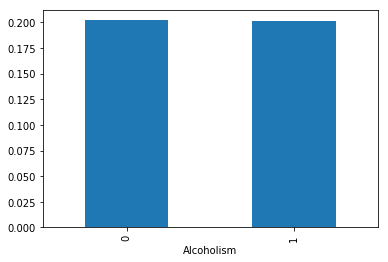

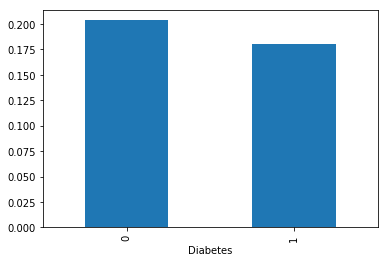

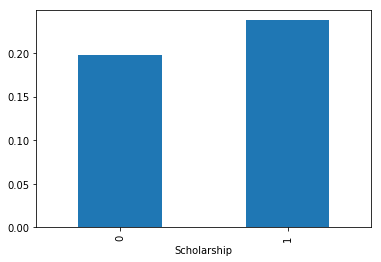

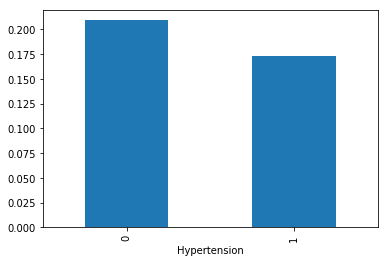

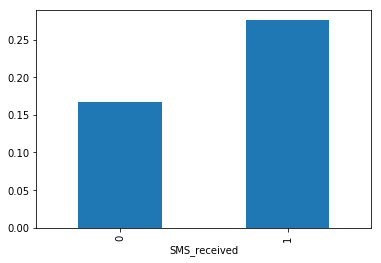

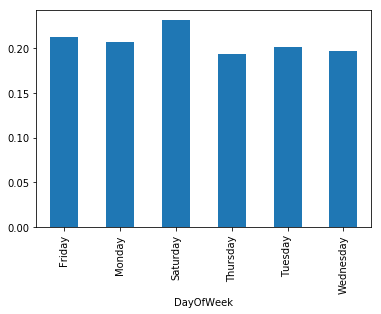

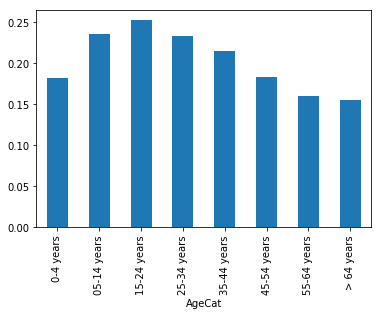

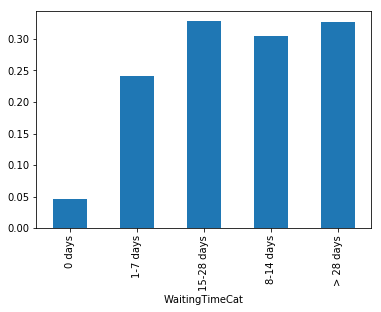

In [26]:


df2 = noShow2.groupby('PreviousNoShowProp').sum()
df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
df2[['NoShowProp']].plot()

df2 = noShow2.groupby('PreviousAppointment').sum()
df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
df2[['NoShowProp']].plot()


def plotNoShow(var):
 df2 = noShow2.groupby([var])['Attended','NoShow'].sum()
 df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
 df2[['NoShowProp']].plot(kind='bar',stacked=True,legend=False)
 df2

    
plotNoShow('Gender')    
plotNoShow('Disabilities')
plotNoShow('Alcoholism')
plotNoShow('Diabetes')
plotNoShow('Scholarship')
plotNoShow('Hypertension')
plotNoShow('SMS_received')
plotNoShow('DayOfWeek')
plotNoShow('AgeCat')
plotNoShow('WaitingTimeCat')



In [ ]:
Now have a look at interactions


In [39]:
def crosstabs(var1,var2):
     display(pd.crosstab(var1,var2,normalize='index' ))

crosstabs(noShow.AgeCat,noShow.Hypertension)
crosstabs(noShow.AgeCat,noShow.Diabetes)
crosstabs(noShow.AgeCat,noShow.Alcoholism)
crosstabs(noShow.AgeCat,noShow.SMS_received)
crosstabs(noShow.AgeCat,noShow.Disability)
crosstabs(noShow.AgeCat,noShow.Gender)


crosstabs(noShow.Hypertension,noShow.Diabetes)
crosstabs(noShow.Hypertension,noShow.Alcoholism)
crosstabs(noShow.Hypertension,noShow.SMS_received)
crosstabs(noShow.Hypertension,noShow.Disability)
crosstabs(noShow.Hypertension,noShow.Gender)



crosstabs(noShow.Diabetes,noShow.Alcoholism)
crosstabs(noShow.Diabetes,noShow.SMS_received)
crosstabs(noShow.Diabetes,noShow.Disability)
crosstabs(noShow.Diabetes,noShow.Gender)

crosstabs(noShow.Alcoholism,noShow.SMS_received)
crosstabs(noShow.Alcoholism,noShow.Disability)
crosstabs(noShow.Alcoholism,noShow.Gender)

crosstabs(noShow.SMS_received,noShow.Disability)
crosstabs(noShow.SMS_received,noShow.Gender)

crosstabs(noShow.Disability,noShow.Gender)




Hypertension,0,1
AgeCat,,
0-4 years,0.999902,0.000098
05-14 years,0.998540,0.001460
15-24 years,0.994290,0.005710
25-34 years,0.955983,0.044017
35-44 years,0.862618,0.137382
45-54 years,0.716198,0.283802
55-64 years,0.576650,0.423350
> 64 years,0.407276,0.592724


Diabetes,0,1
AgeCat,,
0-4 years,0.999707,0.000293
05-14 years,0.998771,0.001229
15-24 years,0.994861,0.005139
25-34 years,0.989414,0.010586
35-44 years,0.957055,0.042945
45-54 years,0.912383,0.087617
55-64 years,0.837613,0.162387
> 64 years,0.766507,0.233493


Alcoholism,0,1
AgeCat,,
0-4 years,0.999902,0.000098
05-14 years,0.998847,0.001153
15-24 years,0.994932,0.005068
25-34 years,0.975484,0.024516
35-44 years,0.953333,0.046667
45-54 years,0.931717,0.068283
55-64 years,0.942590,0.057410
> 64 years,0.975422,0.024578


SMS_received,0,1
AgeCat,,
0-4 years,0.742140,0.257860
05-14 years,0.677833,0.322167
15-24 years,0.674732,0.325268
25-34 years,0.657821,0.342179
35-44 years,0.666988,0.333012
45-54 years,0.668671,0.331329
55-64 years,0.668548,0.331452
> 64 years,0.693953,0.306047


Disability,0,1
AgeCat,,
0-4 years,0.999024,0.000976
05-14 years,0.989013,0.010987
15-24 years,0.983797,0.016203
25-34 years,0.984886,0.015114
35-44 years,0.980561,0.019439
45-54 years,0.979243,0.020757
55-64 years,0.973429,0.026571
> 64 years,0.954523,0.045477


Gender,F,M
AgeCat,,
0-4 years,0.483011,0.516989
05-14 years,0.480369,0.519631
15-24 years,0.711206,0.288794
25-34 years,0.731230,0.268770
35-44 years,0.694837,0.305163
45-54 years,0.685807,0.314193
55-64 years,0.673229,0.326771
> 64 years,0.674304,0.325696


Diabetes,0,1
Hypertension,,
0,0.983579,0.016421
1,0.702491,0.297509


Alcoholism,0,1
Hypertension,,
0,0.977087,0.022913
1,0.939131,0.060869


SMS_received,0,1
Hypertension,,
0,0.677524,0.322476
1,0.684877,0.315123


Disability,0,1
Hypertension,,
0,0.985652,0.014348
1,0.955598,0.044402


Gender,F,M
Hypertension,,
0,0.636803,0.363197
1,0.703592,0.296408


Alcoholism,0,1
Diabetes,,
0,0.970483,0.029517
1,0.958202,0.041798


SMS_received,0,1
Diabetes,,
0,0.677084,0.322916
1,0.703387,0.296613


Disability,0,1
Diabetes,,
0,0.982044,0.017956
1,0.949767,0.050233


Gender,F,M
Diabetes,,
0,0.645656,0.354344
1,0.705779,0.294221


SMS_received,0,1
Alcoholism,,
0,0.676813,0.323187
1,0.747917,0.252083


Disability,0,1
Alcoholism,,
0,0.979817,0.020183
1,0.976786,0.023214


Gender,F,M
Alcoholism,,
0,0.658944,0.341056
1,0.363988,0.636012


Disability,0,1
SMS_received,,
0,0.977280,0.022720
1,0.984894,0.015106


Gender,F,M
SMS_received,,
0,0.634792,0.365208
1,0.682092,0.317908


Gender,F,M
Disability,,
0,0.651515,0.348485
1,0.575636,0.424364


In [ ]:
def plotInt(var,var2):
 df2 = noShow2.groupby([var,var2])['Attended','NoShow'].sum()
 df2['NoShowProp'] = df2['NoShow'] / (df2['Attended'] + df2['NoShow'])
 print(df2)
 #df2[['NoShowProp']].plot(kind='bar',stacked=True,legend=False)
 df2

plotInt('Diabetes','Alcoholism')
plotInt('Diabetes','Disability')
plotInt('Diabetes','Gender')
plotInt('Diabetes','Hypertension')
plotInt('Diabetes','Scholarship')
plotInt('Diabetes','SMS_received')
plotInt('Diabetes','DayOfWeek')
plotInt('Diabetes','PatientHistory')


plotInt('Alcoholism','Disability')
plotInt('Alcoholism','Gender')
plotInt('Alcoholism','Hypertension')
plotInt('Alcoholism','Scholarship')
plotInt('Alcoholism','SMS_received')
plotInt('Alcoholism','DayOfWeek')
plotInt('Alcoholism','PatientHistory')


plotInt('Disability','Gender')
plotInt('Disability','Hypertension')
plotInt('Disability','Scholarship')
plotInt('Disability','SMS_received')
plotInt('Disability','DayOfWeek')
plotInt('Disability','PatientHistory')





In [ ]:
#check for correlation between age and waiting time
plt.scatter(noShow2.Age, noShow2.PreviousNoShowProp, c=noShow2.NoShow)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Previous No-show Prop", fontsize=12)
plt.legend()

There seems to be some evidence of interaction between the variables, so we will keep all columns in the model. For the first model we will drop neighbourhood as there are more than 80 different values and a lot of sparsity. Would be interesting to add back in later to see how XGBoost handles it.

In [40]:
#drop PatientID, AppointmentID and Neightbourhood - check whether we can drop and index column
#noShow = noShow.drop(['PatientID','Neighbourhood','AppointmentID'], axis=1)

noShowFinal = noShow[['No-show', 'Gender', 'AgeCat','Scholarship','Hypertension','Diabetes','Alcoholism','Disabilities','SMS_received','WaitingTimeCat','DayOfWeek','PreviousAppointment','PreviousNoShowProp']].copy()
noShowFinal.info()
#create indicator columns for categorical columns, as requried by XGBoost
model_data = pd.get_dummies(noShowFinal) 
model_data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5751990 to 5660958
Data columns (total 13 columns):
No-show                110527 non-null category
Gender                 110527 non-null object
AgeCat                 110527 non-null object
Scholarship            110527 non-null int64
Hypertension           110527 non-null int64
Diabetes               110527 non-null int64
Alcoholism             110527 non-null int64
Disabilities           110527 non-null int64
SMS_received           110527 non-null int64
WaitingTimeCat         110527 non-null object
DayOfWeek              110527 non-null object
PreviousAppointment    110527 non-null int64
PreviousNoShowProp     48228 non-null float64
dtypes: category(1), float64(1), int64(7), object(4)
memory usage: 11.1+ MB


,Scholarship,Hypertension,Diabetes,Alcoholism,Disabilities,SMS_received,PreviousAppointment,PreviousNoShowProp,No-show_No,No-show_Yes,Gender_F,Gender_M,AgeCat_0-4 years,AgeCat_05-14 years,AgeCat_15-24 years,AgeCat_25-34 years,AgeCat_35-44 years,AgeCat_45-54 years,AgeCat_55-64 years,AgeCat_> 64 years,WaitingTimeCat_0 days,WaitingTimeCat_1-7 days,WaitingTimeCat_15-28 days,WaitingTimeCat_8-14 days,WaitingTimeCat_> 28 days,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
AppointmentID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5751990,0,0,0,0,0,0,0,NaN,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5760144,0,0,1,0,0,0,0,NaN,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5712759,0,0,0,0,0,0,0,NaN,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5637648,0,0,0,0,0,0,0,NaN,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5637728,0,0,0,0,0,1,0,NaN,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


Split the dataset into training data (70%), validation data (20%) and prediction data (10%)

In [41]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=8147), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%


In [42]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)
train_data.info()

(77368, 31)
(22106, 31)
(11053, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77368 entries, 5664524 to 5716188
Data columns (total 31 columns):
Scholarship                  77368 non-null int64
Hypertension                 77368 non-null int64
Diabetes                     77368 non-null int64
Alcoholism                   77368 non-null int64
Disabilities                 77368 non-null int64
SMS_received                 77368 non-null int64
PreviousAppointment          77368 non-null int64
PreviousNoShowProp           33807 non-null float64
No-show_No                   77368 non-null uint8
No-show_Yes                  77368 non-null uint8
Gender_F                     77368 non-null uint8
Gender_M                     77368 non-null uint8
AgeCat_0-4 years             77368 non-null uint8
AgeCat_05-14 years           77368 non-null uint8
AgeCat_15-24 years           77368 non-null uint8
AgeCat_25-34 years           77368 non-null uint8
AgeCat_35-44 years           77368 non-null u

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [43]:
pd.concat([train_data['No-show_Yes'], train_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['No-show_Yes'], validation_data.drop(['No-show_No', 'No-show_Yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [44]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [45]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-1')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [46]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [48]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.3,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100,
                        eval_metric='accuracy')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-11-07 23:33:29 Starting - Starting the training job...
2019-11-07 23:33:30 Starting - Launching requested ML instances...
2019-11-07 23:34:28 Starting - Preparing the instances for training......
2019-11-07 23:35:30 Downloading - Downloading input data...
2019-11-07 23:35:51 Training - Downloading the training image...
2019-11-07 23:36:12 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value accuracy to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','

[87]#011train-error:0.195934#011validation-error:0.193567#011train-accuracy:0.804066#011validation-accuracy:0.806433
[88]#011train-error:0.195792#011validation-error:0.193703#011train-accuracy:0.804208#011validation-accuracy:0.806297
[89]#011train-error:0.195779#011validation-error:0.193522#011train-accuracy:0.804221#011validation-accuracy:0.806478
[90]#011train-error:0.195714#011validation-error:0.193477#011train-accuracy:0.804286#011validation-accuracy:0.806523
[91]#011train-error:0.19583#011validation-error:0.193567#011train-accuracy:0.80417#011validation-accuracy:0.806433
[92]#011train-error:0.195817#011validation-error:0.193567#011train-accuracy:0.804183#011validation-accuracy:0.806433
[93]#011train-error:0.195779#011validation-error:0.193567#011train-accuracy:0.804221#011validation-accuracy:0.806433
[94]#011train-error:0.195727#011validation-error:0.193567#011train-accuracy:0.804273#011validation-accuracy:0.806433
[95]#011train-error:0.195727#011validation-error:0.193567#011train

In [ ]:
#!conda install -y -c conda-forge xgboost 

In [49]:
          
import tarfile
import pickle as pkl
import xgboost

# download the model artifact from AWS S3
!aws s3 cp s3://sagemaker-sf-strategenics/sagemaker/DEMO-xgboost-noShow/output/sagemaker-xgboost-2019-11-07-23-33-29-102/output/model.tar.gz .

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))            

download: s3://sagemaker-sf-strategenics/sagemaker/DEMO-xgboost-noShow/output/sagemaker-xgboost-2019-11-07-23-33-29-102/output/model.tar.gz to ./model.tar.gz


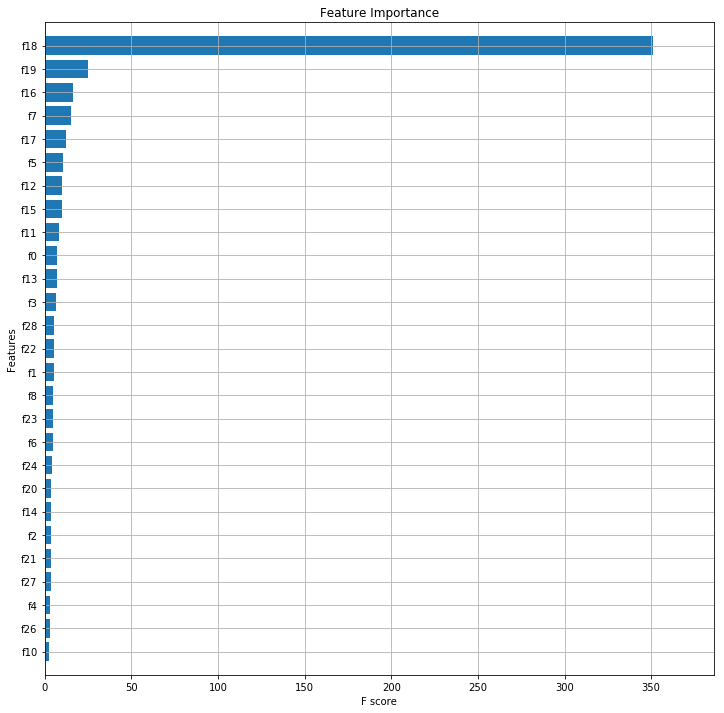

In [50]:
#map_names = dict(zip(model.feature_names, train_data[cols_input].columns))
#model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [ ]:
train_data.info()

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [51]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [52]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [53]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')
test_data.describe()
predictions = predict(test_data.drop(['No-show_No', 'No-show_Yes'], axis=1).as_matrix())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [54]:
pd.crosstab(index=test_data['No-show_Yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'],margins=True)

predictions,0.0,1.0,All
actuals,,,
0,8677,99,8776
1,2147,130,2277
All,10824,229,11053


## In summary, of the 11053 patients, we predicted 229 would be a no-show and 2277 of them actually didn't turn up to the appointment.  We also had 2,147 that were no-shows but we predicted as turning up.  This is less than desirable.  


### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [55]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)